# UCI Heart Disease Notebook

## 1. Import Libraries

In [1]:
# Core data analysis and machine learning
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset loaders
from ucimlrepo import fetch_ucirepo  # UCI ML Repository

# Decision tree visualization
import graphviz
import pydotplus
from IPython.display import display, Markdown, Image

## 2. Load Dataset

In [2]:
# Load the UCI Heart Disease dataset (ID = 45)
heart_disease = fetch_ucirepo(id=45)

# Extract features and labels
X = heart_disease.data.features
y = heart_disease.data.targets

# Display initial shapes
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (303, 13)
Shape of y: (303, 1)


## 3. Basic Preprocessing

In [3]:
# Convert target labels to binary: 0 = No disease, 1 = Has disease
y = np.where(y == 0, 0, 1)

# Show label distribution
unique, counts = np.unique(y, return_counts=True)
print("Label distribution:", dict(zip(unique, counts)))

Label distribution: {np.int64(0): np.int64(164), np.int64(1): np.int64(139)}


## 4. Full Preprocessing with Imputer + OneHotEncoder

In [4]:
# Function to preprocess both numerical and categorical features
def preprocess_features(X):
    categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='mean'), numerical_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
        ]
    )

    X_processed = preprocessor.fit_transform(X)

    # Create column names
    feature_names = numerical_columns.copy()
    if categorical_columns:
        onehot_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
        feature_names.extend(onehot_features)

    return pd.DataFrame(X_processed, columns=feature_names)

## 5. Data Splitting Function

In [5]:
# Split the dataset with stratification and shuffling
def split_dataset(X, y, test_size):
    return train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,         
        shuffle=True,       
        random_state=42     
    )

## 6. Split into Multiple Ratios

In [6]:
# Preprocess data once before splitting
X_processed = preprocess_features(X)

split_ratios = [0.1, 0.2, 0.4, 0.6]

for ratio in split_ratios:
    X_train, X_test, y_train, y_test = split_dataset(X, y, test_size=ratio)

    # Flatten y arrays if needed (to avoid ValueError)
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    print(f"\nTrain/Test ratio = {1 - ratio:.1f}/{ratio:.1f}")
    print("🔹 Train size:", len(y_train), "| Label counts:", pd.Series(y_train).value_counts().to_dict())
    print("🔹 Test  size:", len(y_test),  "| Label counts:", pd.Series(y_test).value_counts().to_dict())


Train/Test ratio = 0.9/0.1
🔹 Train size: 272 | Label counts: {0: 147, 1: 125}
🔹 Test  size: 31 | Label counts: {0: 17, 1: 14}

Train/Test ratio = 0.8/0.2
🔹 Train size: 242 | Label counts: {0: 131, 1: 111}
🔹 Test  size: 61 | Label counts: {0: 33, 1: 28}

Train/Test ratio = 0.6/0.4
🔹 Train size: 181 | Label counts: {0: 98, 1: 83}
🔹 Test  size: 122 | Label counts: {0: 66, 1: 56}

Train/Test ratio = 0.4/0.6
🔹 Train size: 121 | Label counts: {0: 65, 1: 56}
🔹 Test  size: 182 | Label counts: {0: 99, 1: 83}


## 7. Visualize Label Distribution

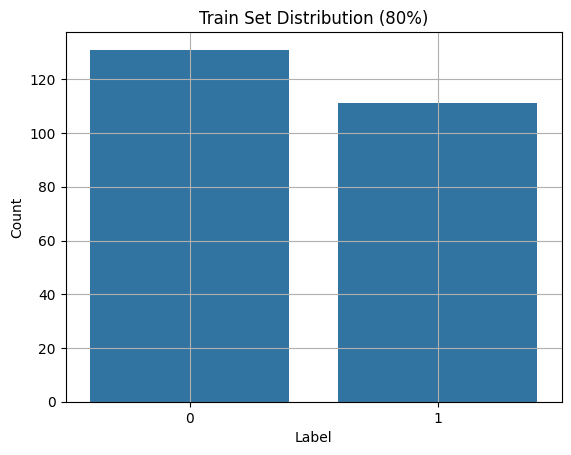

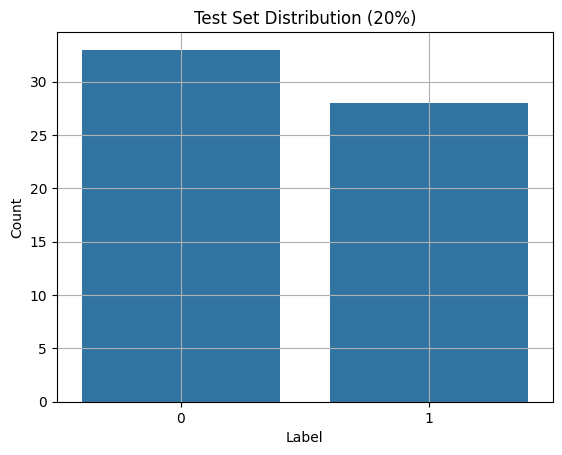

In [7]:
def plot_distribution(y, title):
    y = pd.Series(y.ravel())  # Ensure 1D
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

# Example visualization
X_train, X_test, y_train, y_test = split_dataset(X, y, test_size=0.2)
plot_distribution(y_train, "Train Set Distribution (80%)")
plot_distribution(y_test, "Test Set Distribution (20%)")

## 8. Compare Accuracy across Different Split Ratios

In [8]:
accuracies = []
depths = []

for ratio in split_ratios:
    X_train, X_test, y_train, y_test = split_dataset(X_processed, y, test_size=ratio)
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    depth = clf.get_depth()
    
    accuracies.append(acc)
    depths.append(depth)

    print(f"\nSplit {1 - ratio:.1f}/{ratio:.1f} | Accuracy: {acc:.4f} | Tree Depth: {depth}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Split 0.9/0.1 | Accuracy: 0.6452 | Tree Depth: 10
[[ 8  9]
 [ 2 12]]
              precision    recall  f1-score   support

           0       0.80      0.47      0.59        17
           1       0.57      0.86      0.69        14

    accuracy                           0.65        31
   macro avg       0.69      0.66      0.64        31
weighted avg       0.70      0.65      0.63        31


Split 0.8/0.2 | Accuracy: 0.7705 | Tree Depth: 9
[[22 11]
 [ 3 25]]
              precision    recall  f1-score   support

           0       0.88      0.67      0.76        33
           1       0.69      0.89      0.78        28

    accuracy                           0.77        61
   macro avg       0.79      0.78      0.77        61
weighted avg       0.79      0.77      0.77        61


Split 0.6/0.4 | Accuracy: 0.7377 | Tree Depth: 7
[[45 21]
 [11 45]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.74        66
           1       0.68      

## 9. Visualize Accuracy vs Test Size

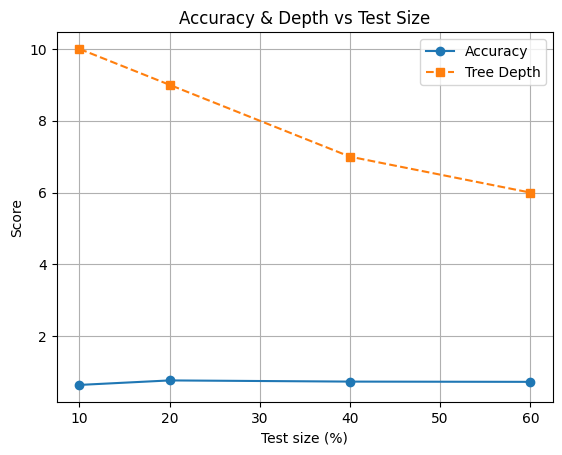

In [9]:
plt.plot([int(r*100) for r in split_ratios], accuracies, marker='o', label="Accuracy")
plt.plot([int(r*100) for r in split_ratios], depths, marker='s', label="Tree Depth", linestyle="--")
plt.title("Accuracy & Depth vs Test Size")
plt.xlabel("Test size (%)")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

## 10 Train Decision Tree for each test size

In [10]:
models = []
split_ratios = [0.1, 0.2, 0.4, 0.6]

for ratio in split_ratios:
    X_train, X_test, y_train, y_test = split_dataset(X_processed, y, test_size=ratio)
    model = DecisionTreeClassifier(criterion="entropy", random_state=42)
    model.fit(X_train, y_train.ravel())
    models.append((ratio, model, X_train, X_test, y_train, y_test))
    print(f"Trained model with test_size = {int(ratio*100)}%")

Trained model with test_size = 10%
Trained model with test_size = 20%
Trained model with test_size = 40%
Trained model with test_size = 60%


## 11. Visualize Decision Trees with Graphviz


Tree for test_size = 10%

(process:19956): Pango-CRITICAL **: 04:28:08.381: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:19956): Pango-CRITICAL **: 04:28:08.381: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:19956): Pango-CRITICAL **: 04:28:08.381: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:19956): Pango-CRITICAL **: 04:28:08.381: pango_font_description_get_family: assertion 'desc != NULL' failed



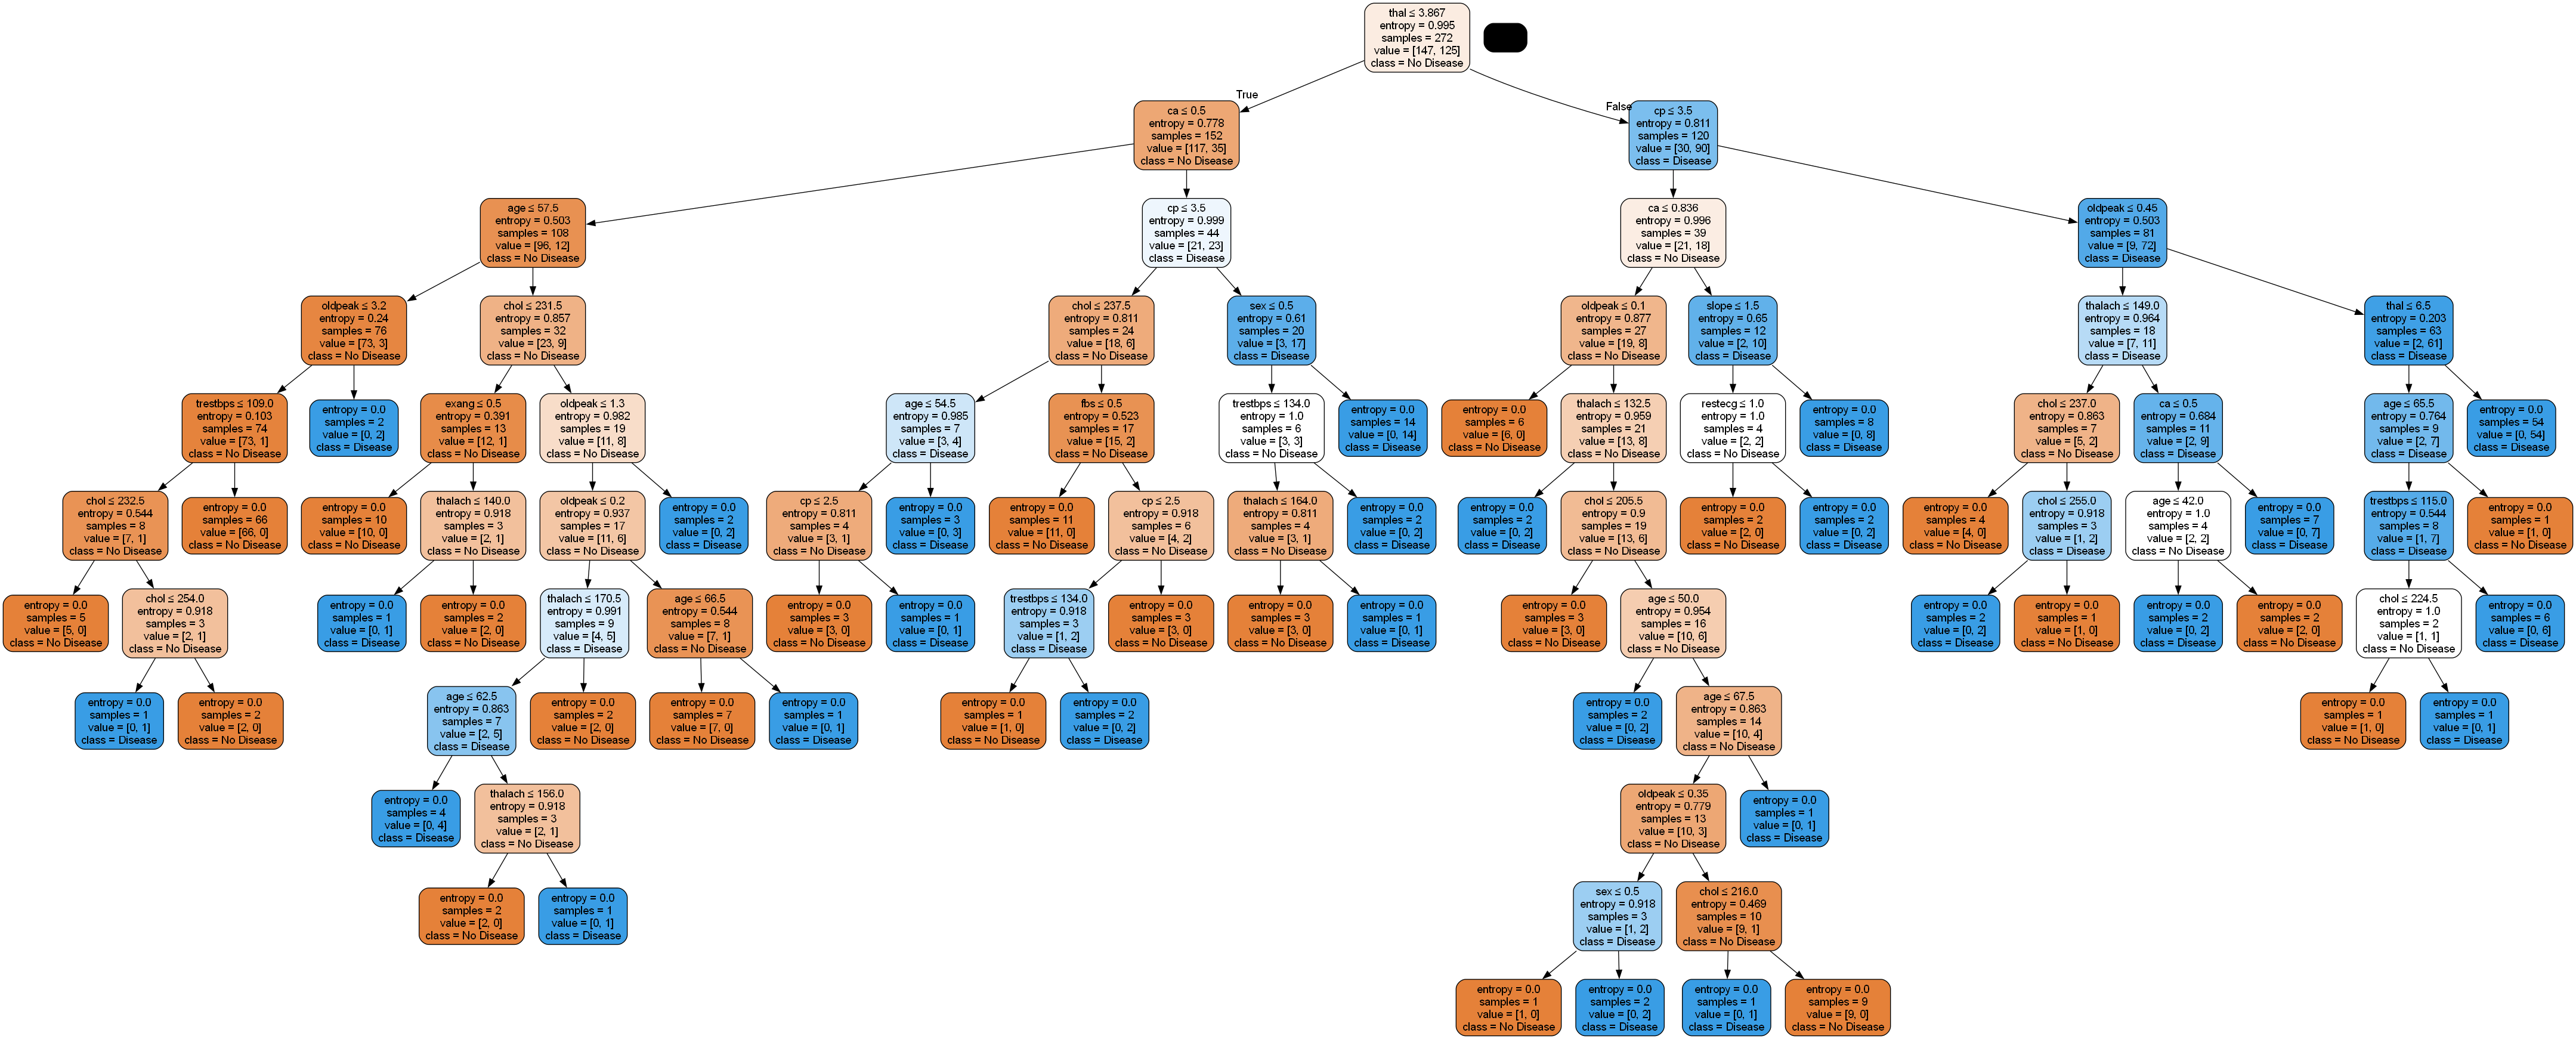


Tree for test_size = 20%

(process:11592): Pango-CRITICAL **: 04:28:09.862: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:11592): Pango-CRITICAL **: 04:28:09.862: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:11592): Pango-CRITICAL **: 04:28:09.862: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:11592): Pango-CRITICAL **: 04:28:09.862: pango_font_description_get_family: assertion 'desc != NULL' failed



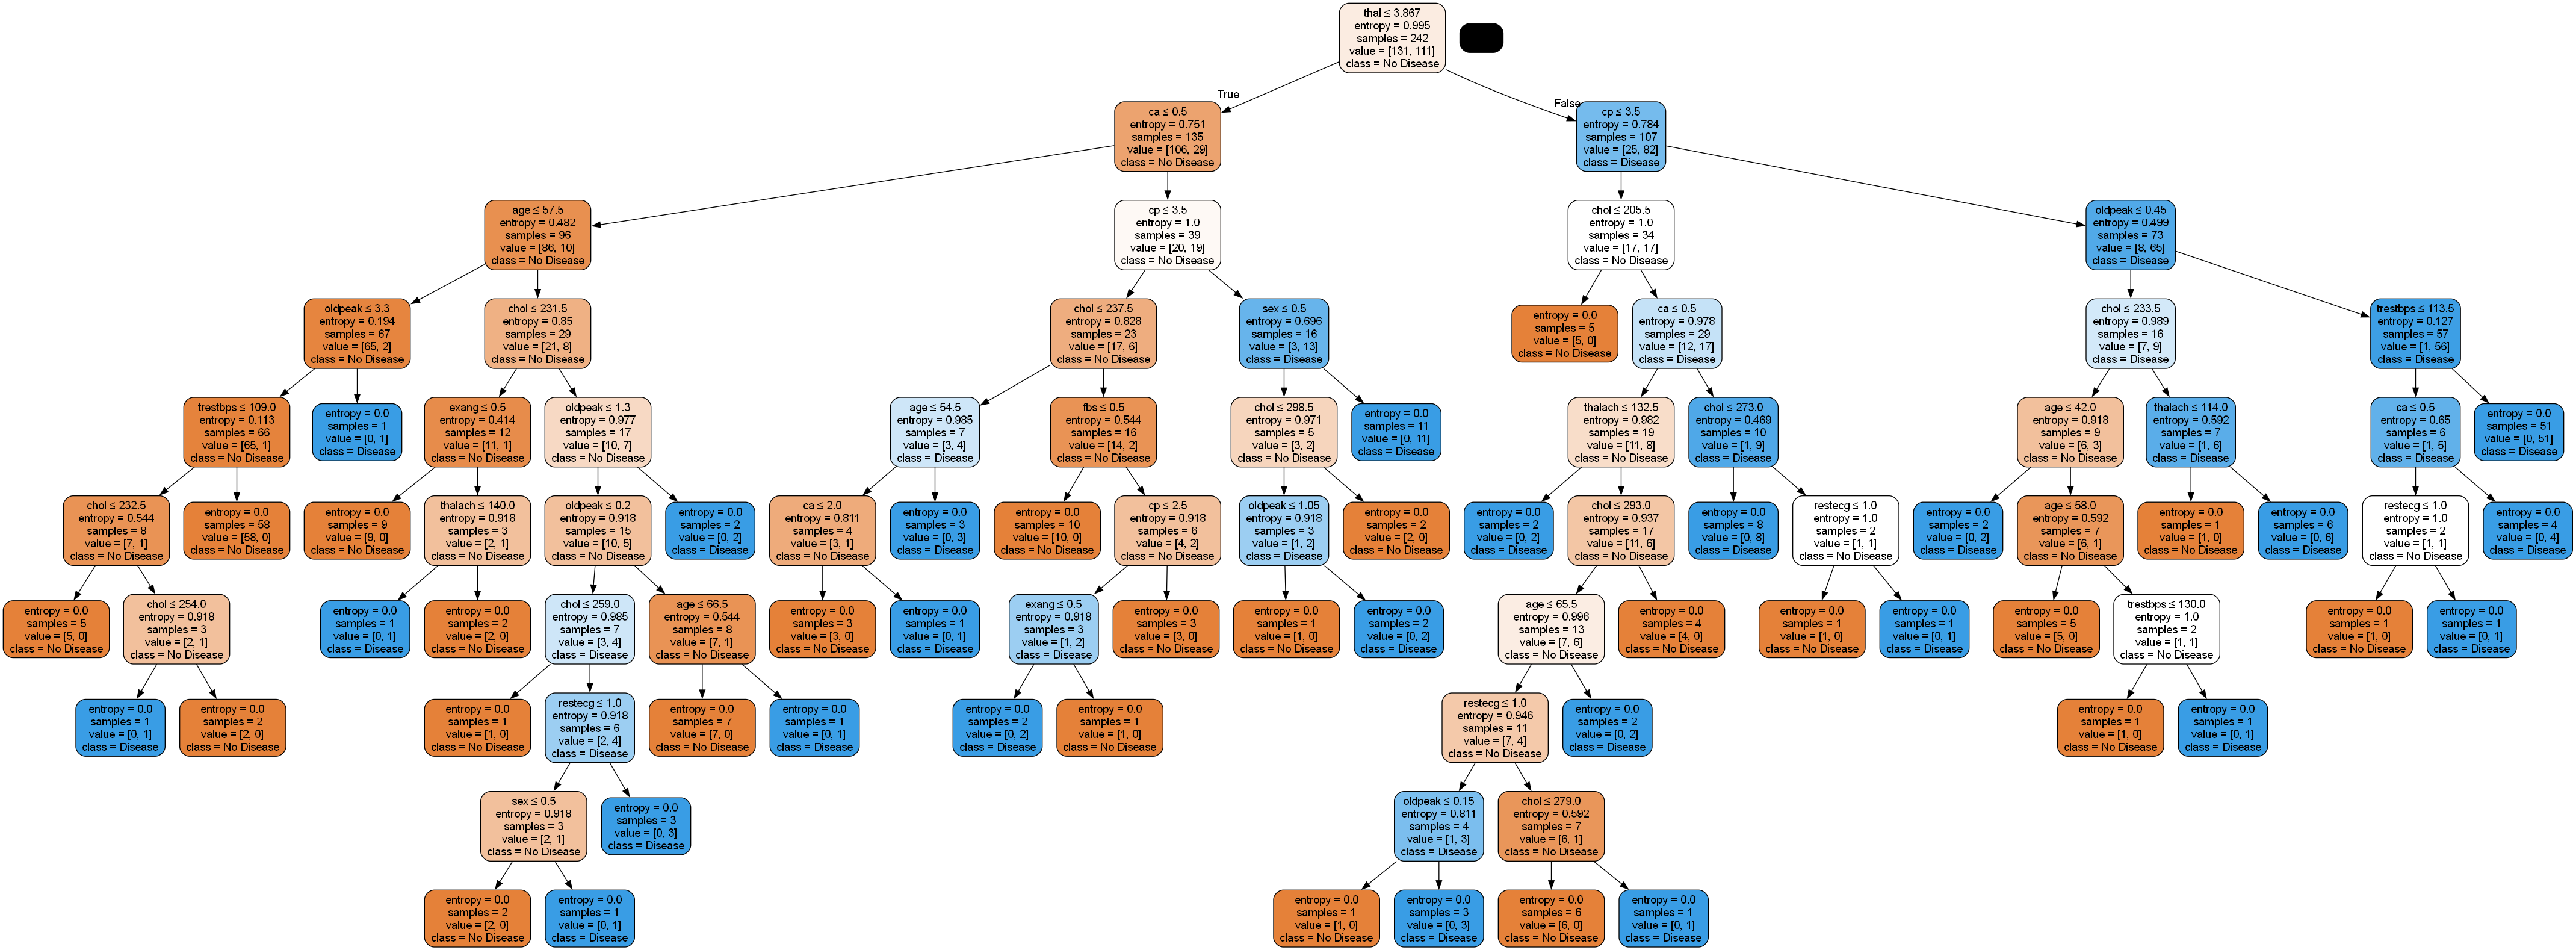


Tree for test_size = 40%

(process:12520): Pango-CRITICAL **: 04:28:11.251: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12520): Pango-CRITICAL **: 04:28:11.251: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12520): Pango-CRITICAL **: 04:28:11.251: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12520): Pango-CRITICAL **: 04:28:11.251: pango_font_description_get_family: assertion 'desc != NULL' failed



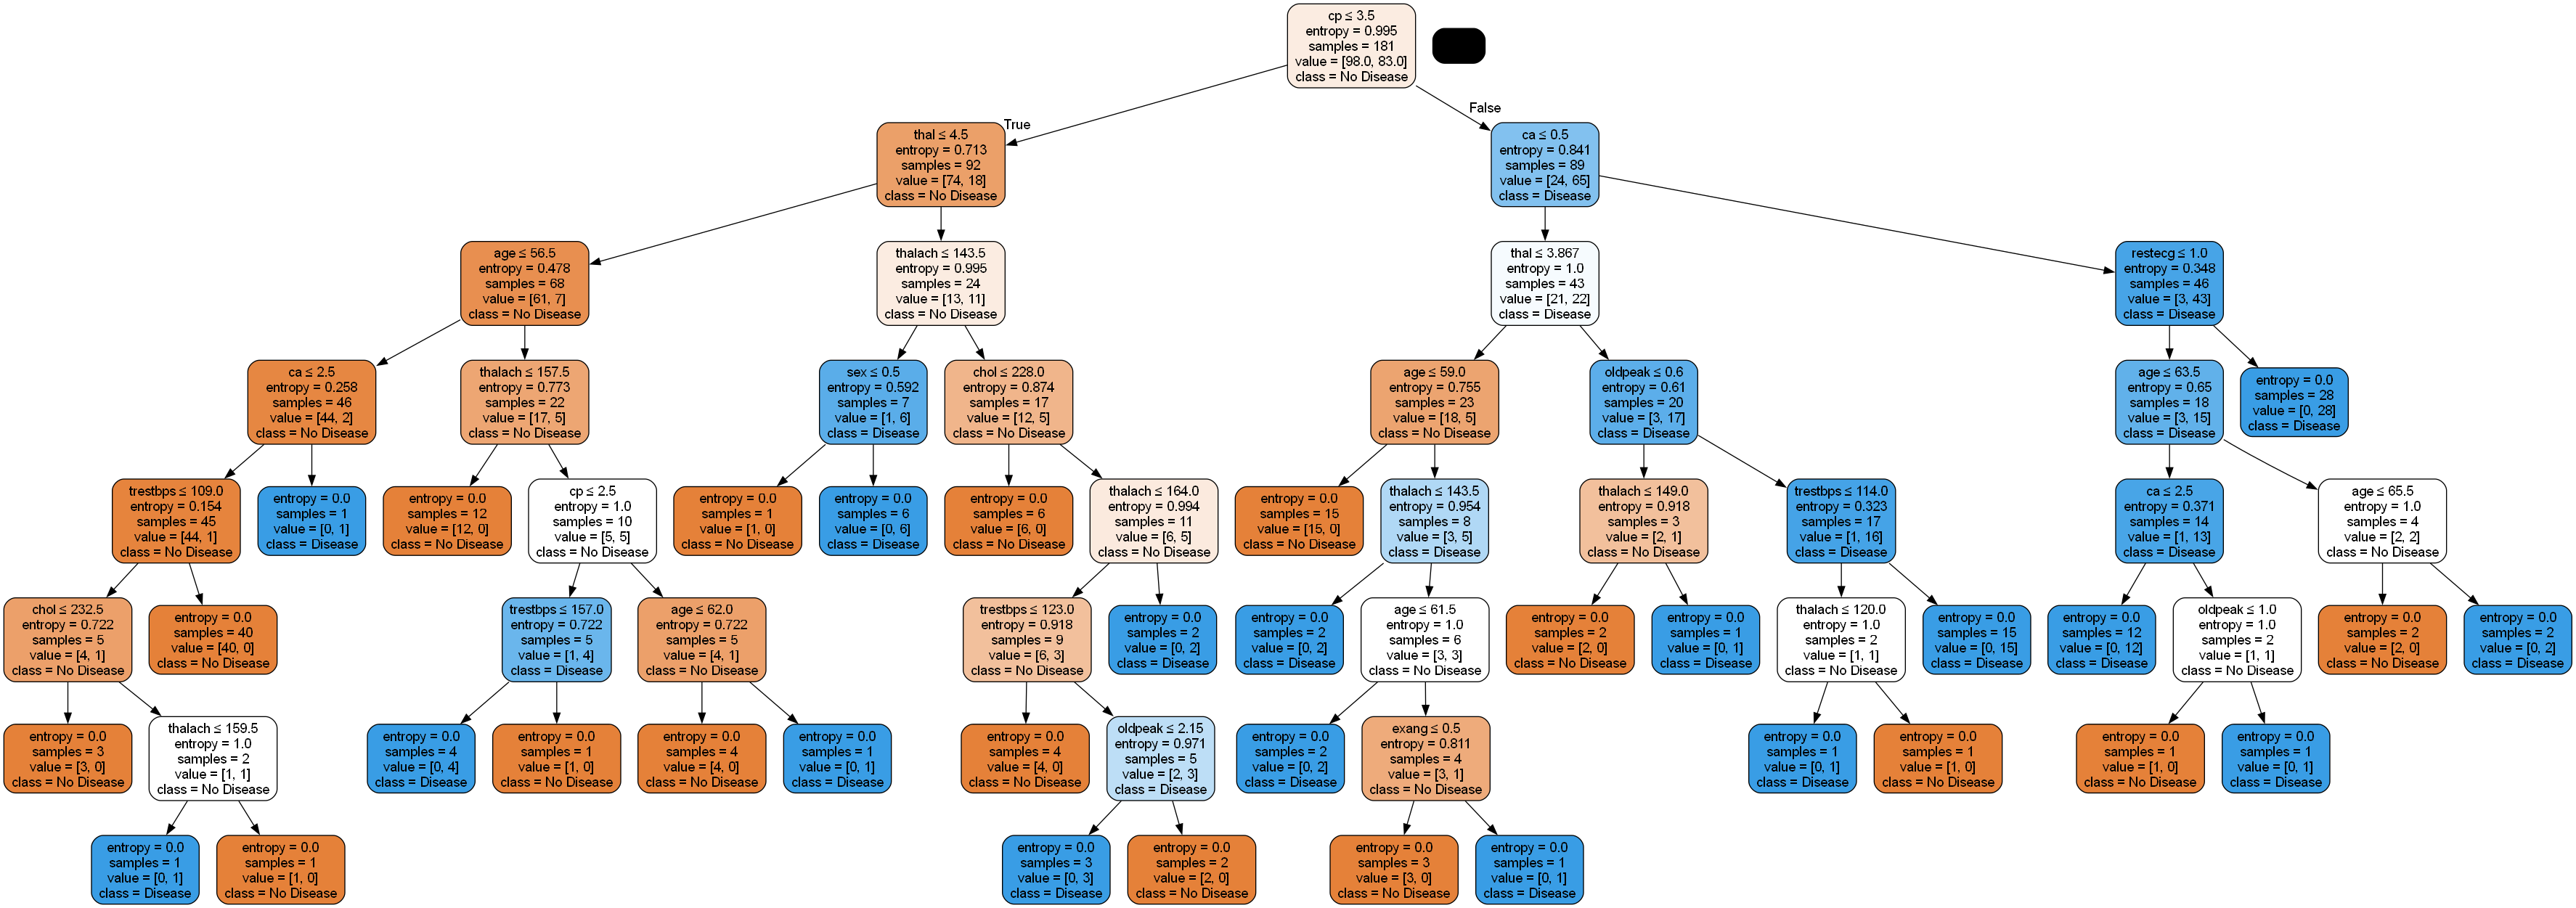


Tree for test_size = 60%

(process:8420): Pango-CRITICAL **: 04:28:12.333: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:8420): Pango-CRITICAL **: 04:28:12.333: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:8420): Pango-CRITICAL **: 04:28:12.333: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:8420): Pango-CRITICAL **: 04:28:12.333: pango_font_description_get_family: assertion 'desc != NULL' failed



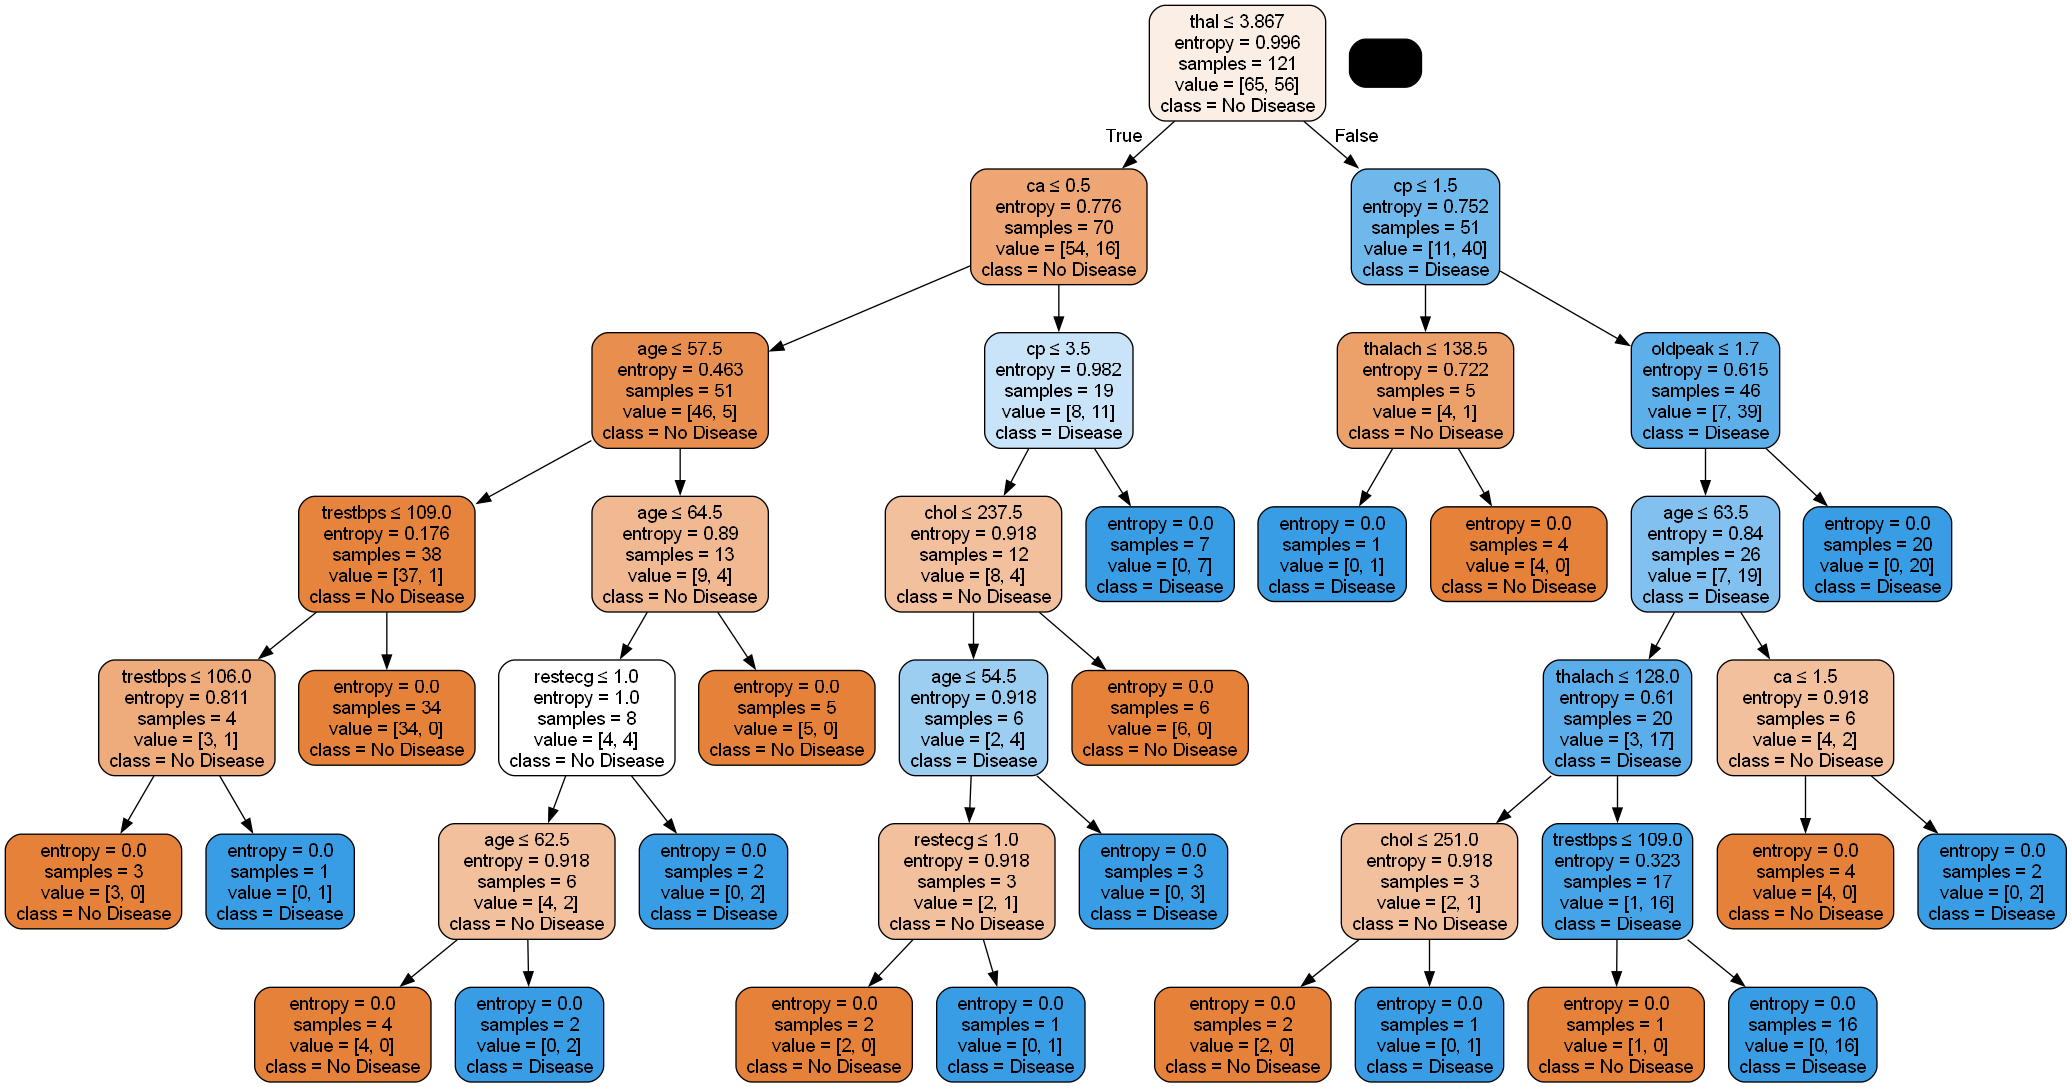

In [11]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image, display

for ratio, model, X_train, _, _, _ in models:
    ratio_str = f"{int(ratio * 100)}%"
    print(f"\nTree for test_size = {ratio_str}")

    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=X_train.columns,
        class_names=['No Disease', 'Disease'],
        filled=True,
        rounded=True,
        special_characters=True
    )

    # ✅ Inject fontname to avoid Pango-CRITICAL error
    dot_data = 'digraph Tree {\nnode [fontname="Arial"];\n' + dot_data.split('\n', 1)[1]

    # ✅ Convert dot to image
    graph = pydotplus.graph_from_dot_data(dot_data)

    # ✅ Optional: save to file if needed
    # graph.write_png(f"tree_entropy_{ratio_str.replace('%','')}.png")

    # ✅ Show image
    image = Image(graph.create_png())
    display(image)

## 12. Evaluate Models (confusion_matrix + classification_report)

In [12]:
for ratio, model, _, X_test, _, y_test in models:
    y_pred = model.predict(X_test)
    ratio_str = f"{int(ratio*100)}%"
    print(f"\nEvaluation for test_size = {ratio_str}")
    print("🔹 Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n🔹 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["No Disease", "Disease"]))
    print("="*60)


Evaluation for test_size = 10%
🔹 Confusion Matrix:
[[ 8  9]
 [ 2 12]]

🔹 Classification Report:
              precision    recall  f1-score   support

  No Disease       0.80      0.47      0.59        17
     Disease       0.57      0.86      0.69        14

    accuracy                           0.65        31
   macro avg       0.69      0.66      0.64        31
weighted avg       0.70      0.65      0.63        31


Evaluation for test_size = 20%
🔹 Confusion Matrix:
[[22 11]
 [ 3 25]]

🔹 Classification Report:
              precision    recall  f1-score   support

  No Disease       0.88      0.67      0.76        33
     Disease       0.69      0.89      0.78        28

    accuracy                           0.77        61
   macro avg       0.79      0.78      0.77        61
weighted avg       0.79      0.77      0.77        61


Evaluation for test_size = 40%
🔹 Confusion Matrix:
[[45 21]
 [11 45]]

🔹 Classification Report:
              precision    recall  f1-score   support

